# Imports

In [1]:
import numpy as np
import pandas as pd
import uproot
import awkward as ak
import itertools
import re

import tqdm
import matplotlib.pyplot as plt

import dimod
from dwave.samplers import SimulatedAnnealingSampler

from scipy.stats import wasserstein_distance

from src.draw_decay_chain import draw_decay_chain
from src.root_to_numpy import root_to_numpy
from src.pair_mapping import create_pair_mapping, pairs_that_contain_jet, build_jet_to_pairs
from src.pair_physics import (
    build_pair_masses,
    build_pair_delta_r,
    build_pair_pt_balance,
    build_pair_pt,
    build_pair_eta,
)
from src.jet_matching import *

import dimod
from dwave.samplers import SimulatedAnnealingSampler


---

# Global Variables

In [2]:
ROOT_FILE = "data/HHH.root"

NUM_EVENTS = 10000      # or None for all
KEEP_EXACTLY_6 = True   # Keep only events with exactly 6 b-tagged jets. If false, events could have >= 6 b-tagged jets

HIGGS_MASS = 125        # Higgs mass hypotesis (GeV);
PT_CUTOFF = 20          # minimum Pt (GeV)
ETA_CUTOFF = 2.5        # maximum absolute eta

MU = 250                # Allowed quadratic displacement from HIGGS_MASS (e.g MU = 400 -> +-20 GeV allowed)
DELR0 = 0               # Prefered angular separation (dR) of jets in pairs
LAM_DELR = 100          # Relative importance of dR term in QUBO
PT_SIGMA = 15           # Pt-balance is more important around HIGGS_MASS, PT_SIGMA changes the width of importance region
LAM_PT = 100            # Relative importance of pt-balance term in QUBO
LAM_DIS = 1e4           # Importance of disjointness combinatorial condition
LAM_3 = 1e5             # Importance of pick exactly 3 pairs combinatorial condition

---

# Dataframes

## Load Dataframes from ROOT
These are **jagged NumPy arrays**, meaning they are NumPy arrays with dtype=object, where each element is itself a NumPy array of variable length.

This differs from standard (rectangular) NumPy ndarrays, which are contiguous, fixed-shape numeric tensors where all rows have the same length.

In [3]:
data = root_to_numpy(ROOT_FILE, num_events=NUM_EVENTS)

nGenJet = data["nGenJet"]

GenJet_pt = data["GenJet_pt"]
GenJet_eta = data["GenJet_eta"]
GenJet_phi = data["GenJet_phi"]
GenJet_mass = data["GenJet_mass"]

GenJet_partonFlavour = data["GenJet_partonFlavour"]
GenJet_hadronFlavour = data["GenJet_hadronFlavour"]

nGenPart = data["nGenPart"]

GenPart_pt = data["GenPart_pt"]
GenPart_eta = data["GenPart_eta"]
GenPart_phi = data["GenPart_phi"]
GenPart_mass = data["GenPart_mass"]

GenPart_pdgId = data["GenPart_pdgId"]
GenPart_genPartIdxMother = data["GenPart_genPartIdxMother"]
GenPart_status = data["GenPart_status"]
GenPart_statusFlags = data["GenPart_statusFlags"]


## Filter Dataframes

### Filter-out Non-b Jets

First, we want to remove any jets that are not b-tagged.

Min: 3
Max: 9
Mean: 5.473
Std: 0.7378827820189329


(array([7.700e+01, 8.340e+02, 0.000e+00, 3.713e+03, 0.000e+00, 5.102e+03,
        2.070e+02, 0.000e+00, 6.600e+01, 1.000e+00]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <BarContainer object of 10 artists>)

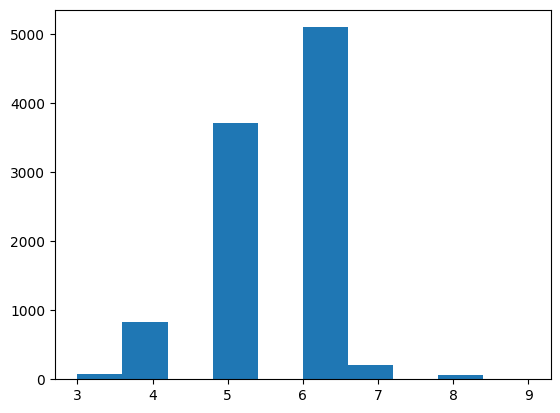

In [4]:
# Build per-jet mask (jagged)
for event in range(NUM_EVENTS):
    event_mask = np.abs(GenJet_hadronFlavour[event]) == 5

    # Apply mask to all jet-level arrays
    GenJet_pt[event] = GenJet_pt[event][event_mask]
    GenJet_eta[event] = GenJet_eta[event][event_mask]
    GenJet_phi[event] = GenJet_phi[event][event_mask]
    GenJet_mass[event] = GenJet_mass[event][event_mask]
    
    GenJet_partonFlavour[event] = GenJet_partonFlavour[event][event_mask]
    GenJet_hadronFlavour[event] = GenJet_hadronFlavour[event][event_mask]

nGenJet = np.array([len(event) for event in GenJet_pt])

print(f'Min: {np.min(nGenJet)}')
print(f'Max: {np.max(nGenJet)}')
print(f'Mean: {np.mean(nGenJet)}')
print(f'Std: {np.std(nGenJet)}')
plt.hist(nGenJet)

### Apply Pt and Eta Cut-offs

Now we apply Pt and Eta cut-offs, as per standard in CMS analyses.

In [5]:
for event in range(NUM_EVENTS):
    event_mask = (
        (GenJet_pt[event] > PT_CUTOFF) &
        (np.abs(GenJet_eta[event]) < ETA_CUTOFF)
    )
    
    GenJet_pt[event] = GenJet_pt[event][event_mask]
    GenJet_eta[event] = GenJet_eta[event][event_mask]
    GenJet_phi[event] = GenJet_phi[event][event_mask]
    GenJet_mass[event] = GenJet_mass[event][event_mask]

    GenJet_partonFlavour[event] = GenJet_partonFlavour[event][event_mask]
    GenJet_hadronFlavour[event] = GenJet_hadronFlavour[event][event_mask]

    nGenJet[event] = len(GenJet_pt[event])

### Wrong Higgs Mass Events
We check the masses of all Higgs bosons (pdgID-25) with Status-62 (last copy before decay), and name event "invalid" if any of 3H has mass different from `HIGGS_MASS` (125 GeV).
There should be no such events, but we check for simulation bugs anyway.

Mean mass: 125.0 GeV
Standard deviation: 0.0 GeV
Invalid events: 0/10000
Invalid event indices: []
Invalid masses: []


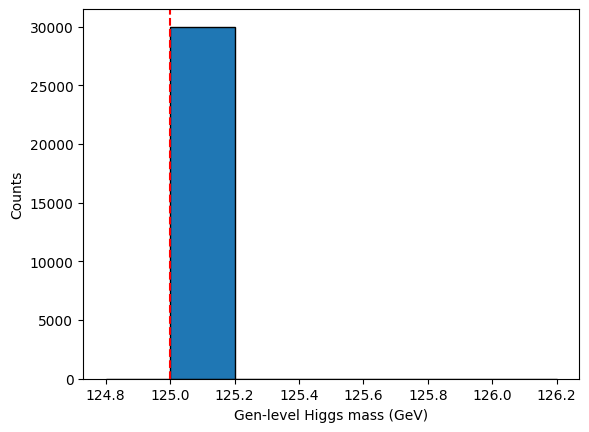

In [6]:
masses = []
invalid_masses = []
invalid_events_masses = []

for event in range(NUM_EVENTS):

    # select masses with status 62
    mask = (GenPart_pdgId[event] == 25) & (GenPart_status[event] == 62)
    event_masses = GenPart_mass[event][mask]

    # find invalid ones in event (use tolerance for floats!)
    mask_invalid = np.abs(event_masses - HIGGS_MASS) > 1e-3

    if np.any(mask_invalid):
        invalid_events_masses.append(event)
        invalid_masses.extend(event_masses[mask_invalid])

    masses.extend(event_masses)

# convert to numpy at end
masses = np.array(masses)
invalid_masses = np.array(invalid_masses)
invalid_events_masses = np.array(invalid_events_masses)


print(f'Mean mass: {np.mean(masses)} GeV')
print(f'Standard deviation: {np.std(masses)} GeV')
print(f'Invalid events: {len(invalid_events_masses)}/{NUM_EVENTS}')
print(f'Invalid event indices: {invalid_events_masses}')
print(f'Invalid masses: {invalid_masses}')

bin_width = 0.2

bins = np.arange(
    HIGGS_MASS - bin_width,
    HIGGS_MASS + bin_width + 1,
    bin_width
)

plt.hist(masses, bins=bins, edgecolor='black')
plt.axvline(HIGGS_MASS, color='red', linestyle='--')
plt.xlabel("Gen-level Higgs mass (GeV)")
plt.ylabel("Counts")
plt.show()

### Less Then 6 b-tagged Jet Events
For each event, we check how many valid Gen-level jets are identified as b-jets (by `GenJet_hadronFlavour == 5`), and select events with <6 b-tagged jets as 'invalid'.

Mean b-tagged jets: 4.8886
Standard deviation: 0.9376513424509133
Invalid events: 7278/10000
Invalid events: [   1    2    3 ... 9997 9998 9999]
Invalid numbers: [3 4 4 ... 5 4 5]


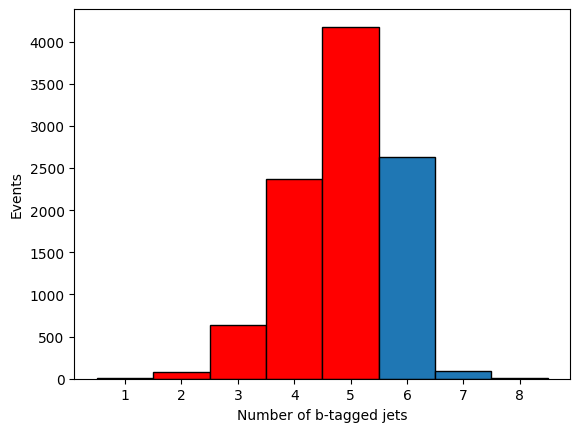

In [7]:
num_b_tagged_jets = []
for event in range(NUM_EVENTS):
    count = np.sum(np.abs(GenJet_hadronFlavour[event]) == 5)
    num_b_tagged_jets.append(count)

num_b_tagged_jets = np.array(num_b_tagged_jets)

mask_invalid = num_b_tagged_jets < 6

invalid_events_b_jets = np.where(mask_invalid)[0]
invalid_number = num_b_tagged_jets[mask_invalid]

print(f'Mean b-tagged jets: {np.mean(num_b_tagged_jets)}')
print(f'Standard deviation: {np.std(num_b_tagged_jets)}')
print(f'Invalid events: {len(invalid_events_b_jets)}/{NUM_EVENTS}')
print(f'Invalid events: {invalid_events_b_jets}')
print(f'Invalid numbers: {invalid_number}')


bins = np.arange(
    np.min(num_b_tagged_jets),
    np.max(num_b_tagged_jets) + 2
) - 0.5

counts, edges, patches = plt.hist(
    num_b_tagged_jets,
    bins=bins,
    edgecolor='black'
)

# Color bins where value < 6
for i, patch in enumerate(patches):
    bin_center = (edges[i] + edges[i+1]) / 2
    if bin_center < 6:
        patch.set_facecolor('red')

plt.xlabel("Number of b-tagged jets")
plt.ylabel("Events")
plt.xticks(range(np.min(num_b_tagged_jets), np.max(num_b_tagged_jets) + 1))
plt.show()


### Filter-out Invalid Events

1. We have indices `invalid_events_masses` of events where Higgs' masses are not equal to `HIGGS_MASS` - we consider these faulty from the simulation and remove them.
2. We have indices `invalid_events_b_jets` of events where <6 b-tagged jets exist - in these events, it is imposible to pick 3 pairs, so we remove them too.

In [8]:
invalid_events = np.int32(np.unique(np.concatenate([invalid_events_masses, invalid_events_b_jets])))
print(f'Unique invalid events to filter-out: {len(invalid_events)}/{NUM_EVENTS}')
print(f'After filtering, there should be {NUM_EVENTS - len(invalid_events)} ({(NUM_EVENTS - len(invalid_events)) / NUM_EVENTS * 100}%) of events left.')

Unique invalid events to filter-out: 7278/10000
After filtering, there should be 2722 (27.22%) of events left.


Let's filter-out invalid events:

In [9]:
event_mask = np.ones(NUM_EVENTS, dtype=bool)
event_mask[invalid_events] = False

nGenJet = nGenJet[event_mask]

GenJet_pt = GenJet_pt[event_mask]
GenJet_eta = GenJet_eta[event_mask]
GenJet_phi = GenJet_phi[event_mask]
GenJet_mass = GenJet_mass[event_mask]

GenJet_partonFlavour = GenJet_partonFlavour[event_mask]
GenJet_hadronFlavour = GenJet_hadronFlavour[event_mask]

nGenPart = nGenPart[event_mask]

GenPart_pt = GenPart_pt[event_mask]
GenPart_eta = GenPart_eta[event_mask]
GenPart_phi = GenPart_phi[event_mask]
GenPart_mass = GenPart_mass[event_mask]

GenPart_pdgId = GenPart_pdgId[event_mask]
GenPart_genPartIdxMother = GenPart_genPartIdxMother[event_mask]
GenPart_status = GenPart_status[event_mask]
GenPart_statusFlags = GenPart_statusFlags[event_mask]

ORIGINAL_NUM_EVENTS = NUM_EVENTS
NUM_EVENTS = len(nGenJet)   # We now update global variable to match the new number of events


### (Optional) Keep Only 6 b-jet Events

Technically, QUBO approach works on N > 6 b-jet events. But if we, for any reason, want to use only events with N = 6, uncomment the cell bellow.

In [10]:
if KEEP_EXACTLY_6:
    exact6_mask = np.ones(NUM_EVENTS, dtype=bool)
    exact6_mask[nGenJet!=6] = False
    
    nGenJet = nGenJet[exact6_mask]
    
    GenJet_pt = GenJet_pt[exact6_mask]
    GenJet_eta = GenJet_eta[exact6_mask]
    GenJet_phi = GenJet_phi[exact6_mask]
    GenJet_mass = GenJet_mass[exact6_mask]
    
    GenJet_partonFlavour = GenJet_partonFlavour[exact6_mask]
    GenJet_hadronFlavour = GenJet_hadronFlavour[exact6_mask]
    
    nGenPart = nGenPart[exact6_mask]
    
    GenPart_pt = GenPart_pt[exact6_mask]
    GenPart_eta = GenPart_eta[exact6_mask]
    GenPart_phi = GenPart_phi[exact6_mask]
    GenPart_mass = GenPart_mass[exact6_mask]
    
    GenPart_pdgId = GenPart_pdgId[exact6_mask]
    GenPart_genPartIdxMother = GenPart_genPartIdxMother[exact6_mask]
    GenPart_status = GenPart_status[exact6_mask]
    GenPart_statusFlags = GenPart_statusFlags[exact6_mask]
    
    NUM_EVENTS = len(nGenJet)   # We now update global variable to match the new number of events
    
    print(f'Number of events remaining: {NUM_EVENTS}/{ORIGINAL_NUM_EVENTS}')

Number of events remaining: 2626/10000


---

# Pair Variables

Our QUBO/BQM for jet-assignment does not use binary tuples `y_ij = (jet_i, jet_j)` as variables for pairing jets. Instead, we create all unique pairs, and treat each pair as a single binary object `x_i` representing which pair should be picked. 

For example, 6 jets can make 15 unique pairs:

{'0': (0, 1),
 '1': (0, 2),
 '2': (0, 3),
 '3': (0, 4),
 '4': (0, 5),
 '5': (1, 2),
 '6': (1, 3),
 '7': (1, 4),
 '8': (1, 5),
 '9': (2, 3),
 '10': (2, 4),
 '11': (2, 5),
 '12': (3, 4),
 '13': (3, 5),
 '14': (4, 5)}

 This is why we need to calculate properties for each pair.

 *Hint: use `map = create_pair_mapping(num_jets)` to create mapping dictionary for any number of jets.*

In [11]:
example_map = create_pair_mapping(6)
print(example_map)

{'0': (0, 1), '1': (0, 2), '2': (0, 3), '3': (0, 4), '4': (0, 5), '5': (1, 2), '6': (1, 3), '7': (1, 4), '8': (1, 5), '9': (2, 3), '10': (2, 4), '11': (2, 5), '12': (3, 4), '13': (3, 5), '14': (4, 5)}


### Number of Pairs (nPairs)

In [12]:
nPairs = np.array([len(create_pair_mapping(int(n_jets))) for n_jets in nGenJet], dtype=np.int32)

print(nGenJet[:10])
print(nPairs[:10])

[6 6 6 6 6 6 6 6 6 6]
[15 15 15 15 15 15 15 15 15 15]


### Pair Invariant Masses (Pair_mass)

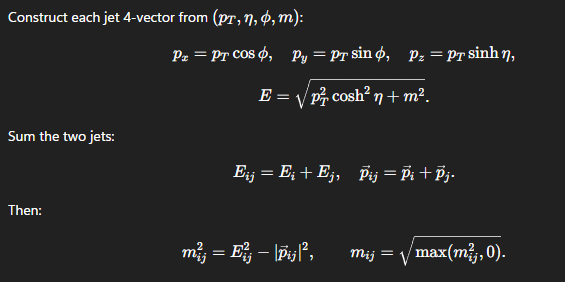

In [13]:
Pair_mass = build_pair_masses(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)

print(Pair_mass[:2])
print([len(row) for row in Pair_mass[:10]])

[[427.5047115155245 130.29980105936588 174.3985404741591
  196.22811070067317 177.47679719948118 285.94418687675375
  187.5536410177819 122.76035447775361 178.35673409563495
  171.12671219600014 166.507061592165 104.45099013180004
  41.14152204249122 125.23846612291621 117.11191866391516]
 [179.79552244106813 90.98559096853256 137.41261285481863
  96.22388308501111 108.39711835877516 101.78716386905177
  68.42518689998644 129.507895839342 73.30103988390206 97.82463802910996
  66.41428396082604 91.70383690878477 83.37419944135422 32.5592385412386
  81.1018941549558]]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


### Pair Angular Separation (Pair_delR)

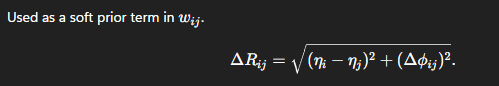

In [14]:
Pair_delR = build_pair_delta_r(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)

print(Pair_delR[:2])
print([len(row) for row in Pair_delR[:10]])

[[3.298151060951873 0.9372229767834408 1.9426074008453889
  2.2512499233674883 1.9695356370577437 2.860921173259862
  1.7225921169115688 1.1693166909291322 1.801182529476777
  2.6320746347186907 2.7851562847763423 1.304019534273702
  0.5734651771955047 2.455797873154072 2.2218150622444206]
 [2.2049149917173176 1.0737353884665353 2.360142475632214
  1.3583120158147284 1.7060963331357224 2.40049145478435
  1.292223947866793 3.483319263217518 1.4030848593780592
  3.037643888483776 1.3804839242944225 2.4982482353282185
  2.6263947721450633 0.6967036255706767 3.040300745229183]]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


### Pair pt-Balance (Pair_ptBalance)

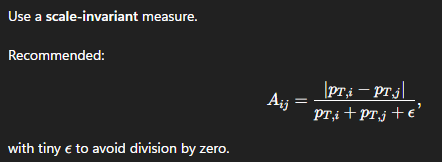

In [15]:
Pair_ptBalance = build_pair_pt_balance(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)

print(Pair_ptBalance[:2])
print([len(row) for row in Pair_ptBalance[:10]])

[[0.006798215602687152 0.20258478196826338 0.42785163129563863
  0.4360098613350109 0.4416826388108481 0.19605657843126806
  0.4222816758452842 0.43048764945690426 0.43619416327292915
  0.24664511818130994 0.25604090709809824 0.2625943188565057
  0.010029141645751671 0.017053729951292677 0.00702578995642035]
 [0.38062149019979763 0.4368327285206941 0.5038265891741214
  0.5067919181687995 0.541539425658856 0.0674212255298621
  0.15243764311052943 0.1563248497997916 0.2026984534974366
  0.08589924993207214 0.08985061497547446 0.13715156569764891
  0.0039820992856202456 0.051863328877742455 0.04789112030214474]]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


### Pair Transverse Momentum (Pair_pt)

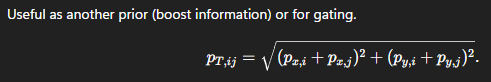

In [16]:
Pair_pt = build_pair_pt(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)

print(Pair_pt[:2])
print([len(row) for row in Pair_pt[:10]])

[[36.31593334670017 260.6435391990194 153.58013052607038
  139.60981071827402 155.13457528117522 75.61318302122142
  206.32294578734727 213.61104394595694 181.25395017580007
  64.49981886568736 53.514128833439386 140.98319451945912
  129.7241827681114 45.133438671991385 57.37116709014511]
 [126.88813030687952 169.27787069233915 100.95244248779485
  141.4591440657078 126.57080030576779 40.54762019996715
  94.11746702834908 15.340944649008536 93.89351388475669
  11.921985862327137 84.41172201442062 37.47070324767319
  22.35683764991085 74.85548360323477 5.605087526716374]]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


### Pair Pseudorapidity (Pair_eta)

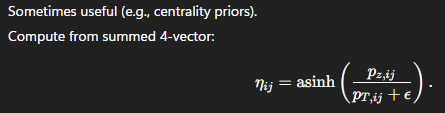

In [17]:
Pair_eta = build_pair_eta(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)

print(Pair_eta[:2])
print([len(row) for row in Pair_eta[:10]])

pair_lengths_ok = (
    np.array_equal(nPairs, np.array([len(row) for row in Pair_mass], dtype=np.int32))
    and np.array_equal(nPairs, np.array([len(row) for row in Pair_delR], dtype=np.int32))
    and np.array_equal(nPairs, np.array([len(row) for row in Pair_ptBalance], dtype=np.int32))
    and np.array_equal(nPairs, np.array([len(row) for row in Pair_pt], dtype=np.int32))
    and np.array_equal(nPairs, np.array([len(row) for row in Pair_eta], dtype=np.int32))
)

[[2.300723689439983 0.9682904453082758 1.4878956452280294
  1.430027622331948 1.3786660989484356 -0.08412622013742732
  0.10927159362016906 -0.11713390171653398 -0.06453093990141215
  1.49693941412346 1.2839466311931778 0.6751324353217028
  0.8169403476678654 1.7910345416284614 1.1734313738138826]
 [1.3632576531785632 1.1885065367585004 1.7848581050397145
  1.5795204457529541 1.6121022979435025 0.6164809268011093
  0.661516545403382 2.6052193740682674 0.7666573996498358
  2.687013406775121 1.1740538425254041 1.7033762476200964
  2.689189874905636 1.3826993392997617 4.140939147920274]]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


In [18]:
print(f"All pair arrays aligned with nPairs: {pair_lengths_ok}")

All pair arrays aligned with nPairs: True


---

# Jet Matching

Since we don't have a way to trace-back all the constituent particles of Gen-jets to their b-quarks and Higgses, we perform "truth matching" by calculating dR for every quark-jet pair, and greedy pick the best matches.

Later, we can introduce dR cut-off for "resolved" condition.

In [19]:
GenJet_truthAssignment, Pair_truthAssignment = build_truth_assignments_all_events(
    GenPart_pdgId, GenPart_status, GenPart_genPartIdxMother, GenPart_eta, GenPart_phi,
    GenJet_eta, GenJet_phi
    )

We can check specific event:

Jet Assignments: [0 1 0 2 1 2]
Pair Assignments: [0 1 0 0 0 0 0 1 0 0 0 0 0 1 0]


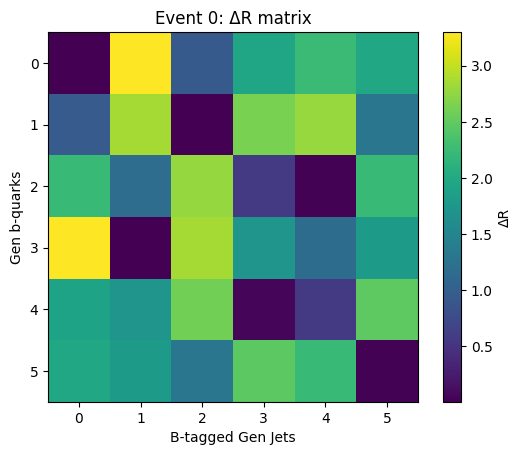

In [20]:
event = 0

print(f'Jet Assignments: {GenJet_truthAssignment[event]}')
print(f'Pair Assignments: {Pair_truthAssignment[event]}')

b_indices = np.where(GenPart_status[event] == 23)[0]

b_etas = np.float32(GenPart_eta[event][b_indices])
b_phis = np.float32(GenPart_phi[event][b_indices])

jet_etas = np.float32(GenJet_eta[event])
jet_phis = np.float32(GenJet_phi[event])

# reshape for broadcasting
b_eta = b_etas[:, None]      # shape (6,1)
b_phi = b_phis[:, None]      # shape (6,1)

jet_eta = jet_etas[None, :]  # shape (1,n_jets)
jet_phi = jet_phis[None, :]  # shape (1,n_jets)

deta = b_eta - jet_eta
dphi = delta_phi(b_phi, jet_phi)

deltaR_matrix = np.sqrt(deta**2 + dphi**2)

plt.imshow(deltaR_matrix, cmap="viridis")
plt.colorbar(label="ΔR")
plt.xlabel("B-tagged Gen Jets")
plt.ylabel("Gen b-quarks")
plt.title(f"Event {event}: ΔR matrix")
plt.show()

## "True" Mass Distributions

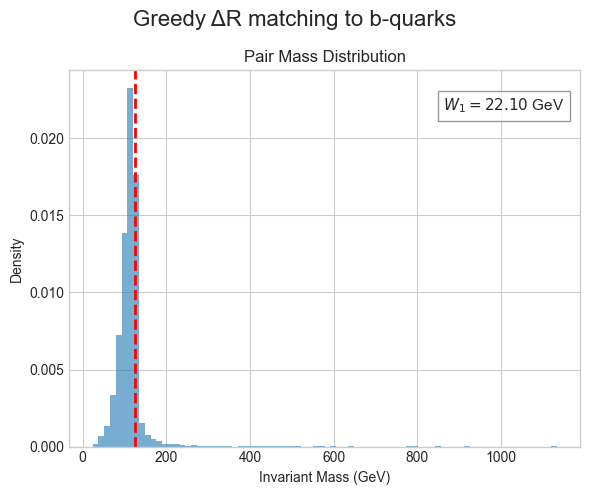

In [21]:
true_masses = np.array([])
for event in range(NUM_EVENTS):
    true_pairs_indices = np.where(Pair_truthAssignment[event] == 1)[0]
    true_masses = np.append(true_masses, Pair_mass[event][true_pairs_indices])

true_masses

data = true_masses

plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(6, 5))

xmin = np.min(true_masses)
xmax = np.max(true_masses)

# Exact W1 to delta at H
W1 = np.mean(np.abs(true_masses - HIGGS_MASS))

ax.hist(
    true_masses,
    bins=80,
    density=True,
    range=(xmin, xmax),
    histtype="stepfilled",
    alpha=0.6
)

ax.axvline(HIGGS_MASS, linestyle="--", color="red", linewidth=2)

ax.set_title("Pair Mass Distribution")
ax.set_xlabel("Invariant Mass (GeV)")
ax.set_ylabel("Density")

ax.text(
    0.97, 0.93,
    f"$W_1 = {W1:.2f}$ GeV",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=11,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

plt.suptitle("Greedy ΔR matching to b-quarks", fontsize=16)
plt.tight_layout()
plt.show()


---

# Build QUBO/BQM

We are now going to build a BQM model for jet-assignment. It consists of three parts:

1. Physics - main objective Hamiltonian to fit dijet mass to Higgs, to minimize angular separation, and pt-balance.
2. Disjointness - combinatorial constraint to disallow picking pairs that share the same jet.
3. Cardinality - combinatorial constraint to require exactly 3 pairs picked. (This one can be modified later to include less than 3 pairs)

First, we will implement combinatorial constraints (2 and 3), since they must be true no matter how we define the physics part. This will allow us to build physics part term-by-term and assess how they contribute.

## Physics Objective

The **key modelling part** of our BQM is the discriminator that should pair jets according to expected physics.
This discriminator is manually designed based on the set of reasonable physical properties that we expect correct pairs to exhibit. It includes 3 terms:

1. Mass term - forces solver to pick pairs that are closest to Higgs' mass.
2. Separation term - penalizes picking pairs that consist of jets which are either too collimated or too far apart.
3. Pt-balance term - penalizes picking pairs which jets' transverse momenta are too disbalanced (one much bigger than the other)

Important: We can't really know whether these 3 terms are enough, too much, or even correct thing to include in pairing model. This is why we will be adding them one-by-one and assessing the results against benchmark.

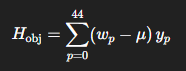

### Mass term

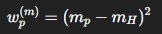

### Delta R Term

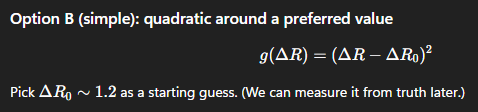

### Pt-Balance Term

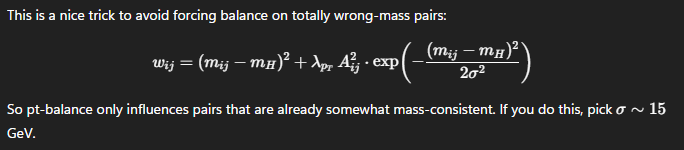

## Disjointness Constraint

A very obvious constraint to assigning pairs of jets to parent Higgs particles is that no jet can originate from two different Higgses. That said, we must penalize any result that chooses at least 2 pairs that share a jet. For example, picking pairs 0 = (0,1), 3 = (0,4), and 9 = (2,3) should be penalized because jet_0 can't be in two pairs at once.

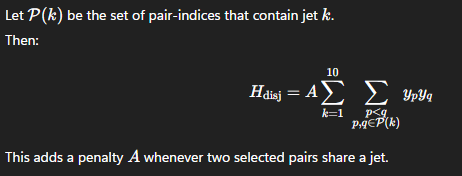

## Exactly 3 Pairs Constraint

Since we filtered out events with <6 b-tagged jets, **we assume that jets in remaining events DO map to parent Higgs bosons 1-to-1**. Of course, this is not always true, and this represents a rough approximation for the initial experimental run.

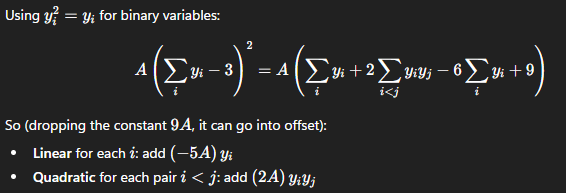

## Build BQM

In [22]:
def build_bqm(event, case: int, mu=MU, delR0=DELR0, lam_delR=LAM_DELR, pt_sigma=PT_SIGMA, lam_pt=LAM_PT, lam_dis=LAM_DIS, lam_3=LAM_3):

    # Setup
    num_jets = nGenJet[event]
    num_pairs = nPairs[event]
    map = create_pair_mapping(num_jets)

    # Initialization
    bqm = dimod.BinaryQuadraticModel({}, {}, 0, vartype='BINARY')

    # Physics terms
    w_mass = (Pair_mass[event] - HIGGS_MASS)**2
    w_delR = lam_delR * (Pair_delR[event] - delR0)**2
    # w_pt = lam_pt * Pair_ptBalance[event]**2 * np.exp(- (w_mass**2) / (2 * pt_sigma**2))
    w_pt = lam_pt * Pair_ptBalance[event]**2
    
    # Pick which terms to use
    if case == 0:   w = w_mass
    elif case == 1: w = w_mass + w_delR
    elif case == 2: w = w_mass + w_delR + w_pt
    else: ValueError("Pick cases 0, 1, or 2.")
    
    # Physics term BQM
    for i in range(num_pairs):
        bqm.add_linear(f'y{i}', w[i] - mu)
    
    # Disjointness term BQM
    jet_to_pairs = build_jet_to_pairs(map, num_jets)

    for k in range(num_jets):
        Pk = jet_to_pairs[k]
        for p, q in itertools.combinations(Pk, 2):
            bqm.add_interaction(f"y{p}", f"y{q}", lam_dis)
    
    # Exactly 3 term BQM
    for i in range(num_pairs):
        bqm.add_linear(f'y{i}', -5 * lam_3)

    for i in range(num_pairs):
        for j in range(i+1, num_pairs):
            bqm.add_quadratic(f"y{i}", f"y{j}", 2 * lam_3)
    
    bqm.offset += 9 * lam_3

    return bqm

---

# Solve QUBO

In [23]:
sampler = SimulatedAnnealingSampler()
num_reads = 1000
num_sweeps = 1

## Case 0: Mass Term Only

In [24]:
case = 0

bqm_masses_0 = np.array([])
for event in tqdm.tqdm(range(NUM_EVENTS)):
    bqm = build_bqm(event, case)
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    df = sampleset.aggregate().to_pandas_dataframe().sort_values(by="energy")

    # Fix numeric column order
    def extract_index(col):
        return int(re.findall(r'\d+', col)[0])

    var_cols = [c for c in df.columns if c not in ['energy', 'num_occurrences']]
    sorted_vars = sorted(var_cols, key=extract_index)

    df = df[sorted_vars + ['energy', 'num_occurrences']]

    # --- Extract lowest-energy row ---
    best_row = df.iloc[0]

    # Binary solution (only y variables)
    var_cols = [c for c in df.columns if c not in ['energy', 'num_occurrences']]
    solution = best_row[var_cols].to_numpy(dtype=int)

    # Indices where solution == 1
    solution_pairs = [int(c[1:]) for c in var_cols if best_row[c] == 1]

    # Energy and occurrences
    solution_energy = best_row['energy']
    solution_num_occurrences = int(best_row['num_occurrences'])

    bqm_masses_0 = np.append(bqm_masses_0, Pair_mass[event][solution_pairs])


100%|██████████| 2626/2626 [08:02<00:00,  5.44it/s]


## Case 1: Mass + Delta R Terms

In [25]:
case = 1

bqm_masses_1 = np.array([])
for event in tqdm.tqdm(range(NUM_EVENTS)):
    bqm = build_bqm(event, case)
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    df = sampleset.aggregate().to_pandas_dataframe().sort_values(by="energy")

    # Fix numeric column order
    def extract_index(col):
        return int(re.findall(r'\d+', col)[0])

    var_cols = [c for c in df.columns if c not in ['energy', 'num_occurrences']]
    sorted_vars = sorted(var_cols, key=extract_index)

    df = df[sorted_vars + ['energy', 'num_occurrences']]

    # --- Extract lowest-energy row ---
    best_row = df.iloc[0]

    # Binary solution (only y variables)
    var_cols = [c for c in df.columns if c not in ['energy', 'num_occurrences']]
    solution = best_row[var_cols].to_numpy(dtype=int)

    # Indices where solution == 1
    solution_pairs = [int(c[1:]) for c in var_cols if best_row[c] == 1]

    # Energy and occurrences
    solution_energy = best_row['energy']
    solution_num_occurrences = int(best_row['num_occurrences'])

    bqm_masses_1 = np.append(bqm_masses_1, Pair_mass[event][solution_pairs])


100%|██████████| 2626/2626 [08:09<00:00,  5.37it/s]


## Case 2: Mass + Delta R + Pt-Balance Terms

In [26]:
case = 2

bqm_masses_2 = np.array([])
for event in tqdm.tqdm(range(NUM_EVENTS)):
    bqm = build_bqm(event, case)
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    df = sampleset.aggregate().to_pandas_dataframe().sort_values(by="energy")

    # Fix numeric column order
    def extract_index(col):
        return int(re.findall(r'\d+', col)[0])

    var_cols = [c for c in df.columns if c not in ['energy', 'num_occurrences']]
    sorted_vars = sorted(var_cols, key=extract_index)

    df = df[sorted_vars + ['energy', 'num_occurrences']]

    # --- Extract lowest-energy row ---
    best_row = df.iloc[0]

    # Binary solution (only y variables)
    var_cols = [c for c in df.columns if c not in ['energy', 'num_occurrences']]
    solution = best_row[var_cols].to_numpy(dtype=int)

    # Indices where solution == 1
    solution_pairs = [int(c[1:]) for c in var_cols if best_row[c] == 1]

    # Energy and occurrences
    solution_energy = best_row['energy']
    solution_num_occurrences = int(best_row['num_occurrences'])

    bqm_masses_2 = np.append(bqm_masses_2, Pair_mass[event][solution_pairs])


100%|██████████| 2626/2626 [08:07<00:00,  5.39it/s]


# Results

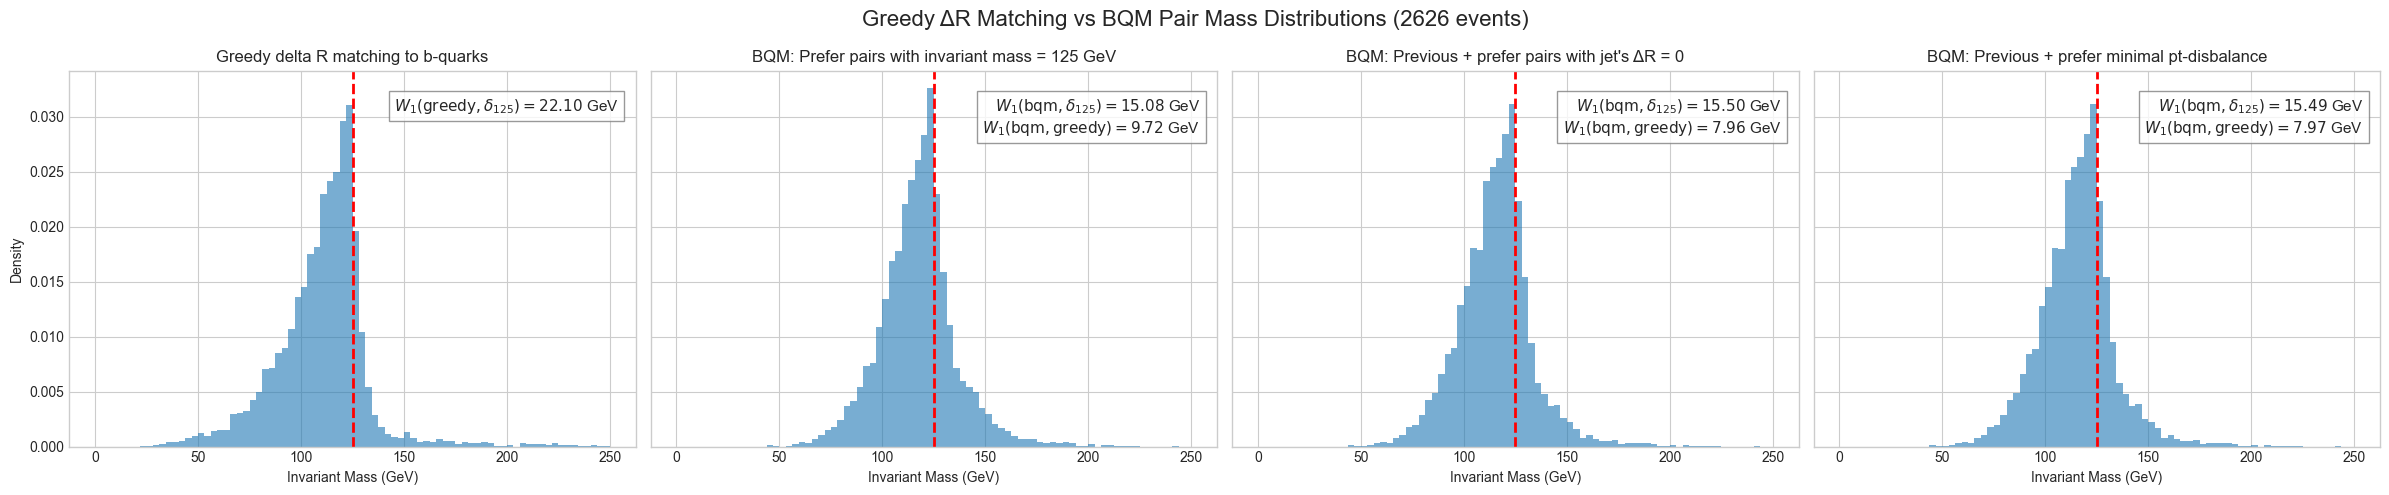


 HHH → 6b  |  BQM Jet Assignment Configuration

[BQM SOLVER]
  Sampler used               : <dwave.samplers.sa.sampler.SimulatedAnnealingSampler object at 0x0000019F77E4CAD0>
  Number of reads            : 1000
  Number of sweeps           : 1

[DATA SELECTION]
  Number of valid events     : 2626/10000
  Higgs mass hypothesis      : 125 GeV
  Jet pT cutoff              : 20 GeV
  Jet |eta| cutoff           : 2.5

[MASS TERM]
  Allowed quadratic window   : MU = 250
  Approximate mass tolerance : ±15.8 GeV

[ANGULAR (ΔR) TERM]
  Preferred ΔR₀              : 0
  Relative QUBO weight (λ_ΔR): 100

[PT BALANCE TERM]
  σ (mass-dependent width)   : 15
  Relative QUBO weight (λ_pT): 100

[COMBINATORIAL CONSTRAINTS]
  Disjointness weight        : 1.00e+04
  Exactly-3-pairs weight     : 1.00e+05


In [29]:
import numpy as np
import matplotlib.pyplot as plt

H = HIGGS_MASS

cases = {
    f"BQM: Prefer pairs with invariant mass = {HIGGS_MASS} GeV": np.asarray(bqm_masses_0),
    f"BQM: Previous + prefer pairs with jet's ΔR = {DELR0}": np.asarray(bqm_masses_1),
    f"BQM: Previous + prefer minimal pt-disbalance": np.asarray(bqm_masses_2),
}

true = np.asarray(true_masses)

# ----------------------------
# W1 helpers (1D)
# ----------------------------
def W1_to_delta(x, H):
    return float(np.mean(np.abs(x - H)))

def W1_empirical(x, y, n_quantiles=4001):
    u = np.linspace(0.0, 1.0, n_quantiles)
    qx = np.quantile(x, u, method="linear")
    qy = np.quantile(y, u, method="linear")
    return float(np.trapezoid(np.abs(qx - qy), u))

# ----------------------------
# Plot
# ----------------------------
plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

xmin = min([true.min()] + [v.min() for v in cases.values()])
xmax = max([true.max()] + [v.max() for v in cases.values()])

# ---- Greedy ΔR matching panel
W1_true_delta = W1_to_delta(true, H)

ax = axes[0]
ax.hist(
    true,
    bins=80,
    density=True,
    range=(0, 250),
    histtype="stepfilled",
    alpha=0.6,
    label="Greedy ΔR matching to b-quarks"
)
ax.axvline(H, linestyle="--", color="red", linewidth=2)
ax.set_title("Greedy delta R matching to b-quarks")
ax.set_xlabel("Invariant Mass (GeV)")
ax.set_ylabel("Density")

ax.text(
    0.97, 0.93,
    f"$W_1(\\mathrm{{greedy}},\\delta_{{125}}) = {W1_true_delta:.2f}$ GeV",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=11,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

# ---- BQM panels
for ax, (label, data) in zip(axes[1:], cases.items()):
    W1_bqm_delta = W1_to_delta(data, H)
    W1_bqm_true  = W1_empirical(data, true)

    ax.hist(
        data,
        bins=80,
        density=True,
        range=(0, 250),
        histtype="stepfilled",
        alpha=0.6,
        label=label
    )
    ax.axvline(H, linestyle="--", color="red", linewidth=2)

    ax.set_title(label)
    ax.set_xlabel("Invariant Mass (GeV)")

    ax.text(
        0.97, 0.93,
        f"$W_1(\\mathrm{{bqm}},\\delta_{{125}}) = {W1_bqm_delta:.2f}$ GeV\n"
        f"$W_1(\\mathrm{{bqm}},\\mathrm{{greedy}}) = {W1_bqm_true:.2f}$ GeV",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
    )

plt.suptitle(f"Greedy ΔR Matching vs BQM Pair Mass Distributions ({NUM_EVENTS} events)", fontsize=16)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(" HHH → 6b  |  BQM Jet Assignment Configuration")
print("="*70)

# --------------------------------------------------
# BQM SOLVER
# --------------------------------------------------
print("\n[BQM SOLVER]")
print(f"  Sampler used               : {sampler}")
print(f"  Number of reads            : {num_reads}")
print(f"  Number of sweeps           : {num_sweeps}")

# --------------------------------------------------
# DATA SELECTION
# --------------------------------------------------
print("\n[DATA SELECTION]")
print(f"  Number of valid events     : {NUM_EVENTS if NUM_EVENTS is not None else 'ALL'}/{ORIGINAL_NUM_EVENTS}")
print(f"  Higgs mass hypothesis      : {HIGGS_MASS} GeV")
print(f"  Jet pT cutoff              : {PT_CUTOFF} GeV")
print(f"  Jet |eta| cutoff           : {ETA_CUTOFF}")

# --------------------------------------------------
# MASS TERM
# --------------------------------------------------
print("\n[MASS TERM]")
print(f"  Allowed quadratic window   : MU = {MU}")
print(f"  Approximate mass tolerance : ±{np.sqrt(MU):.1f} GeV")

# --------------------------------------------------
# ΔR TERM
# --------------------------------------------------
print("\n[ANGULAR (ΔR) TERM]")
print(f"  Preferred ΔR₀              : {DELR0}")
print(f"  Relative QUBO weight (λ_ΔR): {LAM_DELR}")

# --------------------------------------------------
# pT BALANCE TERM
# --------------------------------------------------
print("\n[PT BALANCE TERM]")
print(f"  σ (mass-dependent width)   : {PT_SIGMA}")
print(f"  Relative QUBO weight (λ_pT): {LAM_PT}")

# --------------------------------------------------
# COMBINATORIAL CONSTRAINTS
# --------------------------------------------------
print("\n[COMBINATORIAL CONSTRAINTS]")
print(f"  Disjointness weight        : {LAM_DIS:.2e}")
print(f"  Exactly-3-pairs weight     : {LAM_3:.2e}")